In [1]:
from src.helpers.experiment import create_tsfresh_dataframe
from src.helpers.diabetes.cega import clarke_error_grid
from src.helpers.diabetes.madex import mean_adjusted_exponent_error
from pycaret.regression import setup, create_model, compare_models, predict_model, get_config, pull
from loguru import logger
import warnings
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas

In [14]:
def run(patient, window, horizon):
    print(patient,window,horizon)
    

    train_parameters = {
        'ohio_no': patient,
        'scope': 'train',
        'train_ds_size': 0,
        'window_size': window,
        'prediction_horizon': horizon,
        'minimal_features': False,
    }

    unseen_data_parameters = {
        'ohio_no': patient,
        'scope': 'test',
        'train_ds_size': 0,
        'window_size': window,
        'prediction_horizon': horizon,
        'minimal_features': False,
    }
    
    source_df = create_tsfresh_dataframe(train_parameters)
    clean_df = source_df.drop(
        columns=['start', 'end', 'start_time', 'end_time'])
    print(clean_df.columns)
    
    regressor = setup(clean_df,
        target='label',
        feature_selection=True,
        ignore_low_variance=True,  
        html=False,
        silent=True,
        verbose=False,
        session_id=1974
        )
    print(get_config('prep_pipe'))
    print(get_config('X').columns)
    
    best3 = compare_models(
        exclude=['catboost', 'xgboost'],
        sort='RMSE',
        n_select=3,
        verbose=False
    )
    comparison_df = pull()
    display(comparison_df)
    
    
    output = {}
    output['patient'] = patient
    output['window']  = f'{window}({(window*5)} minutes)'
    output['horizon']  = f'{horizon}({(horizon*5)} minutes)'
    model = create_model(best3[0])
    model_name = model.__str__().split('(')[0]
    logger.info(f'Processing model: {model_name}')
    output['model'] = model
    output['model_name'] = model_name
    pd = predict_model(model)
    (_, res) = clarke_error_grid(pd['label'], pd['Label'], 'Test')
    output['internal_cga_analysis'] = res
    rmse = np.sqrt(mean_squared_error(pd['label'], pd['Label']))
    rmadex = np.sqrt(mean_adjusted_exponent_error(
        pd['label'], pd['Label']))
    output['internal_rmse'] = rmse
    output['internal_rmadex'] = rmadex

    unseen_df = create_tsfresh_dataframe(unseen_data_parameters)
    clean_unseen_df = unseen_df.drop(
        columns=['start', 'end', 'start_time', 'end_time'])
    unseen_pd = predict_model(model, data=clean_unseen_df)
    (_, res) = clarke_error_grid(unseen_pd['label'], unseen_pd['Label'], 'Test')
    output['unseen_cga_analysis'] = res
    rmse = np.sqrt(mean_squared_error(unseen_pd['label'], unseen_pd['Label']))
    rmadex = np.sqrt(mean_adjusted_exponent_error(
        unseen_pd['label'], unseen_pd['Label']))
    output['unseen_rmse'] = rmse
    output['unseen_rmadex'] = rmadex
#     logger.info(output)
    
    return output
    
    
    

2021-07-06 19:15:33.726 | INFO     | src.helpers.experiment:create_ds_name:12 - dataframes/559_train_0_6_6.pkl
2021-07-06 19:15:33.839 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:19 - {'ohio_no': 559, 'scope': 'train', 'train_ds_size': 0, 'window_size': 6, 'prediction_horizon': 6, 'minimal_features': False}


559 6 6


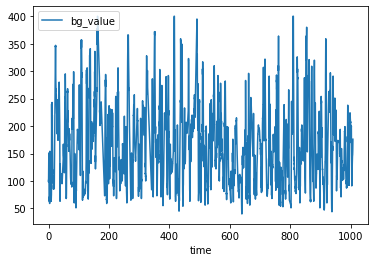

2021-07-06 19:15:34.259 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:22 - Found existing picle file. Continuing...
2021-07-06 19:15:34.260 | INFO     | src.helpers.dataframe:read_df:11 - Attempting to read from pickle file dataframes/559_train_0_6_6.pkl


Index(['bg_value__variance_larger_than_standard_deviation',
       'bg_value__has_duplicate_max', 'bg_value__has_duplicate_min',
       'bg_value__has_duplicate', 'bg_value__sum_values',
       'bg_value__abs_energy', 'bg_value__mean_abs_change',
       'bg_value__mean_change', 'bg_value__mean_second_derivative_central',
       'bg_value__median',
       ...
       'bg_value__permutation_entropy__dimension_6__tau_1',
       'bg_value__permutation_entropy__dimension_7__tau_1',
       'bg_value__query_similarity_count__query_None__threshold_0.0',
       'bg_value__matrix_profile__feature_"min"__threshold_0.98',
       'bg_value__matrix_profile__feature_"max"__threshold_0.98',
       'bg_value__matrix_profile__feature_"mean"__threshold_0.98',
       'bg_value__matrix_profile__feature_"median"__threshold_0.98',
       'bg_value__matrix_profile__feature_"25"__threshold_0.98',
       'bg_value__matrix_profile__feature_"75"__threshold_0.98', 'label'],
      dtype='object', length=788)
Pipelin

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,18.3117,7.298146e+02,26.9821,0.8519,0.1720,0.1234,0.920
gbr,Gradient Boosting Regressor,18.4553,7.374429e+02,27.1311,0.8504,0.1736,0.1254,5.370
rf,Random Forest Regressor,18.1839,7.383950e+02,27.1491,0.8501,0.1724,0.1228,17.088
et,Extra Trees Regressor,18.2996,7.465273e+02,27.2984,0.8486,0.1745,0.1242,10.808
knn,K Neighbors Regressor,22.8758,1.076186e+03,32.7842,0.7818,0.2124,0.1562,0.367
omp,Orthogonal Matching Pursuit,19.6426,1.840573e+03,37.1970,0.6206,0.1842,0.1315,0.029
dt,Decision Tree Regressor,25.5180,1.464704e+03,38.2352,0.7027,0.2371,0.1694,0.448
ada,AdaBoost Regressor,32.3235,1.584824e+03,39.7952,0.6790,0.2904,0.2636,2.630
br,Bayesian Ridge,19.8898,2.266134e+03,41.8092,0.5411,0.1880,0.1334,0.293
lr,Linear Regression,32.7807,2.407364e+03,46.8668,0.5216,0.2861,0.2472,0.627


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,17.5464,693.6326,26.3369,0.8529,0.1730,0.1239
1,18.5797,709.5612,26.6376,0.8631,0.1666,0.1251
2,18.1761,658.0149,25.6518,0.8608,0.1690,0.1235
3,19.1071,825.7236,28.7354,0.8360,0.1780,0.1241
4,17.5527,640.4710,25.3075,0.8744,0.1573,0.1136
5,19.0553,772.5911,27.7955,0.8548,0.1763,0.1269
6,18.8136,771.2194,27.7708,0.8405,0.1801,0.1314
7,18.8215,777.9573,27.8919,0.8403,0.1770,0.1263
8,17.1760,620.6601,24.9131,0.8771,0.1643,0.1177
9,18.2884,828.3150,28.7805,0.8188,0.1783,0.1210


2021-07-06 19:23:32.971 | INFO     | __main__:run:56 - Processing model: LGBMRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,18.3241,721.86,26.8675,0.8573,0.1728,0.1247


2021-07-06 19:23:33.452 | INFO     | src.helpers.experiment:create_ds_name:12 - dataframes/559_test_0_6_6.pkl
2021-07-06 19:23:33.474 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:19 - {'ohio_no': 559, 'scope': 'test', 'train_ds_size': 0, 'window_size': 6, 'prediction_horizon': 6, 'minimal_features': False}


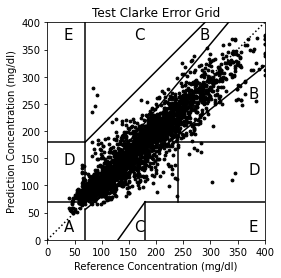

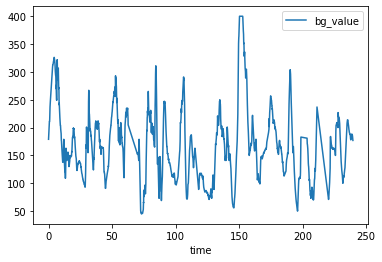

2021-07-06 19:23:33.821 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:22 - Found existing picle file. Continuing...
2021-07-06 19:23:33.823 | INFO     | src.helpers.dataframe:read_df:11 - Attempting to read from pickle file dataframes/559_test_0_6_6.pkl


[{'patient': 559,
  'window': '6(30 minutes)',
  'horizon': '6(30 minutes)',
  'model': LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
                random_state=1974, reg_alpha=0.0, reg_lambda=0.0, silent=True,
                subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
  'model_name': 'LGBMRegressor',
  'internal_cga_analysis': [2645, 487, 4, 100, 0],
  'internal_rmse': 26.867451700519922,
  'internal_rmadex': 2646.0003443505966,
  'unseen_cga_analysis': [2226, 238, 6, 33, 0],
  'unseen_rmse': 22.172681535167513,
  'unseen_rmadex': 180.23918907502562}]

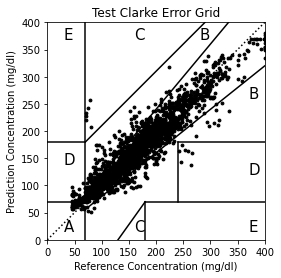

In [15]:
patients = [559]
windows = [6]
horizons = [6]
[run(patient,window, horizon) for patient in patients for window in windows for horizon in horizons]